In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Load Data and examine

In [2]:
# load data
df = pd.read_csv('hotel-reservations.csv')
# check dimensions
df.shape

(119390, 32)

In [3]:
# preview data
df.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [4]:
# Check column names for typos or spaces
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

# Missing Data

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Since the analysis is to do with which countries are most likely to cancel, there is no point in keeping those records missing country

And there are 4 records missing the 'children' attribute. This is statistically insignificant in a dataset of this size, so easiest just to drop them too rather than try and impute them.

In [6]:
df = df.dropna(subset=['country', 'children'])
df.shape

(118898, 32)

There are too many records missing 'agent' and 'company' attributes, so dropping those too

In [7]:
df = df.drop(columns=['agent', 'company'])
df.shape

(118898, 30)

In [8]:
df.isnull().sum().sum()

0

# Problem and Redundant Columns

'reservation_status' includes the status, 'Cancelled', while 'reservation_status_date' gives the date the status changes. If this is before the arrival date, that means a cancellation occurred. Both of these are future information, not known at time of booking and so unsuitable for inclusion in the model.

Another attribute from the future, unknown at time of booking, is 'assigned_room_type', so this is also removed.

In [9]:
df = df.drop(columns=['reservation_status', 'reservation_status_date', 'assigned_room_type'])
df.shape

(118898, 27)

### Dates

There are 4 attributes for arrival dates. This is redundant. I have combined them into a single datetime attribute 'arrival_date'. This will work effectively with tree-based classifiers but may need revisiting for naive bayes or SVM.

In [10]:
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)

df = df.drop(columns=[
    'arrival_date_year',
    'arrival_date_month',
    'arrival_date_day_of_month',
    'arrival_date_week_number'
])

df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
0,Resort Hotel,0,342,0,0,2,0.0,0,BB,PRT,...,0,C,3,No Deposit,0,Transient,0.0,0,0,2015-07-01
1,Resort Hotel,0,737,0,0,2,0.0,0,BB,PRT,...,0,C,4,No Deposit,0,Transient,0.0,0,0,2015-07-01
2,Resort Hotel,0,7,0,1,1,0.0,0,BB,GBR,...,0,A,0,No Deposit,0,Transient,75.0,0,0,2015-07-01
3,Resort Hotel,0,13,0,1,1,0.0,0,BB,GBR,...,0,A,0,No Deposit,0,Transient,75.0,0,0,2015-07-01
4,Resort Hotel,0,14,0,2,2,0.0,0,BB,GBR,...,0,A,0,No Deposit,0,Transient,98.0,0,1,2015-07-01


### Plot to show how ADR changes over time

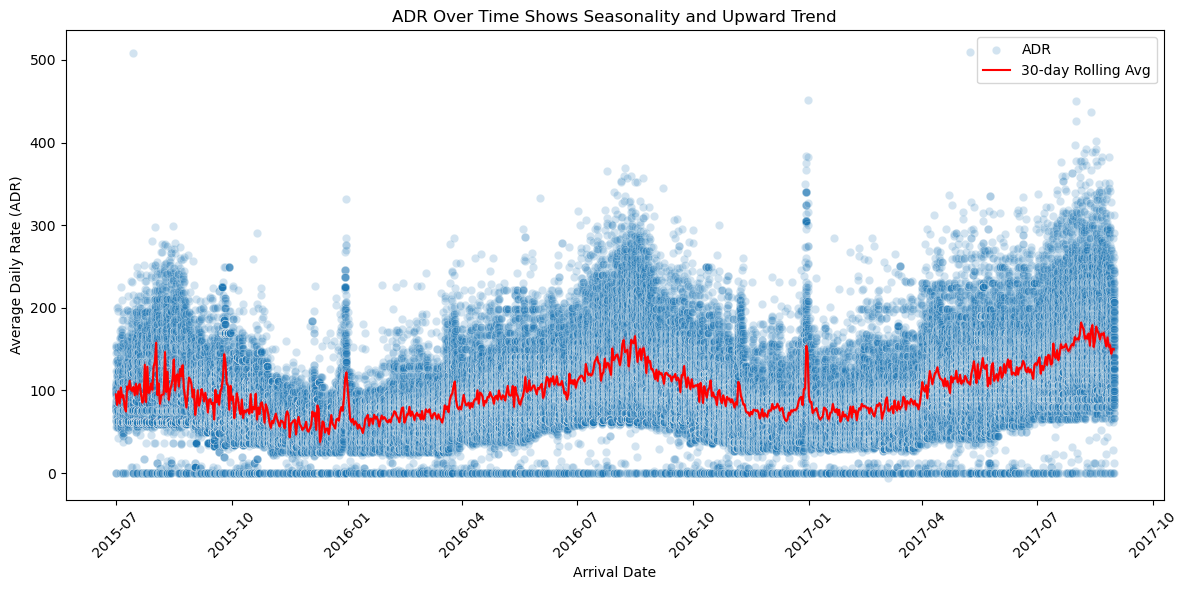

In [11]:
# smooth the trend with a rolling average
df_sorted = df[df['adr'] <= 1000]  # dropping the huge outlier
df_sorted = df_sorted.sort_values(by='arrival_date')
df_sorted['adr_rolling'] = df_sorted['adr'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='arrival_date', y='adr', data=df_sorted, alpha=0.2, label='ADR')
sns.lineplot(x='arrival_date', y='adr_rolling', data=df_sorted, color='red', label='30-day Rolling Avg')

plt.title("ADR Over Time Shows Seasonality and Upward Trend")
plt.xlabel("Arrival Date")
plt.ylabel("Average Daily Rate (ADR)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Further consideration

After further thought, it was decided to extract the month from the arrival date and remove the rest. Weekday/weekend behaviour is captured in the relevant attributes, so the day granularity is likely unnecessary, while looking for seasonal patterns is more in keeping with the goal of the analysis, and this will work better with the models

In [12]:
df['arrival_month'] = df['arrival_date'].dt.month
df = df.drop(columns=['arrival_date'])
df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_month
0,Resort Hotel,0,342,0,0,2,0.0,0,BB,PRT,...,0,C,3,No Deposit,0,Transient,0.0,0,0,7
1,Resort Hotel,0,737,0,0,2,0.0,0,BB,PRT,...,0,C,4,No Deposit,0,Transient,0.0,0,0,7
2,Resort Hotel,0,7,0,1,1,0.0,0,BB,GBR,...,0,A,0,No Deposit,0,Transient,75.0,0,0,7
3,Resort Hotel,0,13,0,1,1,0.0,0,BB,GBR,...,0,A,0,No Deposit,0,Transient,75.0,0,0,7
4,Resort Hotel,0,14,0,2,2,0.0,0,BB,GBR,...,0,A,0,No Deposit,0,Transient,98.0,0,1,7


# Data Types

In [13]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
arrival_month                     

In [14]:
# check there are no fractional children!
df.children.unique()

array([ 0.,  1.,  2., 10.,  3.])

In [15]:
# change children to an int
df = df.astype({'children': 'int64'})

Could change the binaries to bools, but models prefer 1s and 0s. 

Will one-hot-encode objects after checking contents

In [16]:
# List all object (categorical) columns
cat_cols = df.select_dtypes(include='object').columns

# get number columns too
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('is_canceled')

# Show value counts for each
for col in cat_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False))


--- hotel ---
hotel
City Hotel      79302
Resort Hotel    39596
Name: count, dtype: int64

--- meal ---
meal
BB           91863
HB           14434
SC           10638
Undefined     1165
FB             798
Name: count, dtype: int64

--- country ---
country
PRT    48586
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: count, Length: 177, dtype: int64

--- market_segment ---
market_segment
Online TA        56402
Offline TA/TO    24160
Groups           19806
Direct           12448
Corporate         5111
Complementary      734
Aviation           237
Name: count, dtype: int64

--- distribution_channel ---
distribution_channel
TA/TO        97730
Direct       14483
Corporate     6491
GDS            193
Undefined        1
Name: count, dtype: int64

--- reserved_room_type ---
reserved_room_type
A    85601
D    19173
E     6497
F     2890
G     2083
B     1114
C      931
H      601
L        6
P        2
Name: c

Dropping the one Undefined in distribution channel. Unable to assign it to another group, and 1 record is insignificant.

Combining the two lowest room reservations (L and P) into one 'Other' category for slightly cleaner model, tho minimum really

Leaving the Undefined as its own category in 'meal' as it is a considerable number. Might be something that was decided later? But cannot assign it to another group with no evidence and too many to lose.

Need to combine the countries with too few entries. However, combining all the countries with <100 bookings into one 'other' category would result in that category becoming one of the top 10 countries for number of bookings. This 'other' category provides very little information, so this is not ideal. Instead, I decided to combine the countries with less than 100 bookings by continent, reducing the number of features to reduce model complexity, without too much information loss. (Also CN and CHN are both China, combining the two)

In [17]:
df = df[df['distribution_channel'] != 'Undefined']
df['reserved_room_type'] = df['reserved_room_type'].replace(['L', 'P'], 'Other')

In [18]:
country_counts = df['country'].value_counts()
rare_countries = country_counts[country_counts < 100]

rare_countries.sum()

2390

In [19]:
# Combine CN and CHN as they are both China
df['country'] = df['country'].replace('CN', 'CHN')

In [20]:
# Save a copy before combining countries
df.to_csv('hotel_clean_all_countries.csv', index=False)

In [21]:
# define major countries in dataset
major_countries = country_counts[country_counts>100]

# mapping countries to continents
continent_map = {
    'MEX': 'North America', 'EST': 'Europe', 'IRN': 'Asia', 'LTU': 'Europe', 'ZAF': 'Africa',
    'BGR': 'Europe', 'NZL': 'Oceania', 'COL': 'South America', 'UKR': 'Europe', 'MOZ': 'Africa',
    'CHL': 'South America', 'SVK': 'Europe', 'THA': 'Asia', 'SVN': 'Europe', 'ISL': 'Europe',
    'LVA': 'Europe', 'ARE': 'Asia', 'CYP': 'Europe', 'TWN': 'Asia', 'SAU': 'Asia', 'PHL': 'Asia',
    'TUN': 'Africa', 'SGP': 'Asia', 'IDN': 'Asia', 'NGA': 'Africa', 'EGY': 'Africa', 'URY': 'South America',
    'LBN': 'Asia', 'PER': 'South America', 'HKG': 'Asia', 'MYS': 'Asia', 'ECU': 'South America',
    'VEN': 'South America', 'BLR': 'Europe', 'CPV': 'Africa', 'GEO': 'Asia', 'JOR': 'Asia', 'KAZ': 'Asia',
    'CRI': 'North America', 'GIB': 'Europe', 'MLT': 'Europe', 'OMN': 'Asia', 'AZE': 'Asia', 'KWT': 'Asia',
    'MAC': 'Asia', 'QAT': 'Asia', 'IRQ': 'Asia', 'DOM': 'North America', 'PAK': 'Asia', 'BIH': 'Europe',
    'MDV': 'Asia', 'BGD': 'Asia', 'ALB': 'Europe', 'PRI': 'North America', 'SEN': 'Africa', 'CMR': 'Africa',
    'MKD': 'Europe', 'BOL': 'South America', 'PAN': 'North America', 'GNB': 'Africa', 'TJK': 'Asia',
    'VNM': 'Asia', 'CUB': 'North America', 'ARM': 'Asia', 'JEY': 'Europe', 'LBY': 'Africa', 'AND': 'Europe',
    'MUS': 'Africa', 'LKA': 'Asia', 'CIV': 'Africa', 'JAM': 'North America', 'KEN': 'Africa', 'FRO': 'Europe',
    'MNE': 'Europe', 'TZA': 'Africa', 'BHR': 'Asia', 'CAF': 'Africa', 'SUR': 'South America',
    'PRY': 'South America', 'BRB': 'North America', 'GTM': 'North America', 'UZB': 'Asia', 'MCO': 'Europe',
    'GAB': 'Africa', 'GHA': 'Africa', 'ZWE': 'Africa', 'ETH': 'Africa', 'TMP': 'Asia', 'LIE': 'Europe',
    'GGY': 'Europe', 'SYR': 'Asia', 'BEN': 'Africa', 'GLP': 'North America', 'SLV': 'North America',
    'ATA': 'Antarctica', 'MYT': 'Africa', 'ABW': 'North America', 'KHM': 'Asia', 'LAO': 'Asia',
    'STP': 'Africa', 'ZMB': 'Africa', 'MWI': 'Africa', 'IMN': 'Europe', 'COM': 'Africa', 'TGO': 'Africa',
    'UGA': 'Africa', 'KNA': 'North America', 'RWA': 'Africa', 'SYC': 'Africa', 'KIR': 'Oceania',
    'SDN': 'Africa', 'NCL': 'Oceania', 'AIA': 'North America', 'ASM': 'Oceania', 'FJI': 'Oceania',
    'ATF': 'Antarctica', 'LCA': 'North America', 'GUY': 'South America', 'PYF': 'Oceania',
    'DMA': 'North America', 'SLE': 'Africa', 'MRT': 'Africa', 'NIC': 'North America', 'BDI': 'Africa',
    'PLW': 'Oceania', 'MLI': 'Africa', 'CYM': 'North America', 'BFA': 'Africa', 'MDG': 'Africa',
    'MMR': 'Asia', 'NPL': 'Asia', 'BHS': 'North America', 'UMI': 'Oceania', 'SMR': 'Europe',
    'DJI': 'Africa', 'BWA': 'Africa', 'HND': 'North America', 'VGB': 'North America', 'NAM': 'Africa'
}


# Apply the transformation
df['country'] = df['country'].apply(lambda x: x if x in major_countries else continent_map.get(x, "Other"))

# Removing the 3 from Antarctica as they seem unlikely!
df = df[df['country'] != 'Antarctica']

df['country'].unique()

array(['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'Asia',
       'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CHN', 'GRC', 'ITA', 'NLD',
       'DNK', 'RUS', 'SWE', 'AUS', 'Europe', 'CZE', 'BRA', 'FIN',
       'Africa', 'LUX', 'IND', 'North America', 'MAR', 'SRB',
       'South America', 'AUT', 'TUR', 'AGO', 'ISR', 'DZA', 'KOR', 'HUN',
       'Other', 'Oceania', 'JPN'], dtype=object)

# Outliers

In [22]:
num_cols = num_cols.drop('is_repeated_guest')  # this is really a categorical
num_cols

Index(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

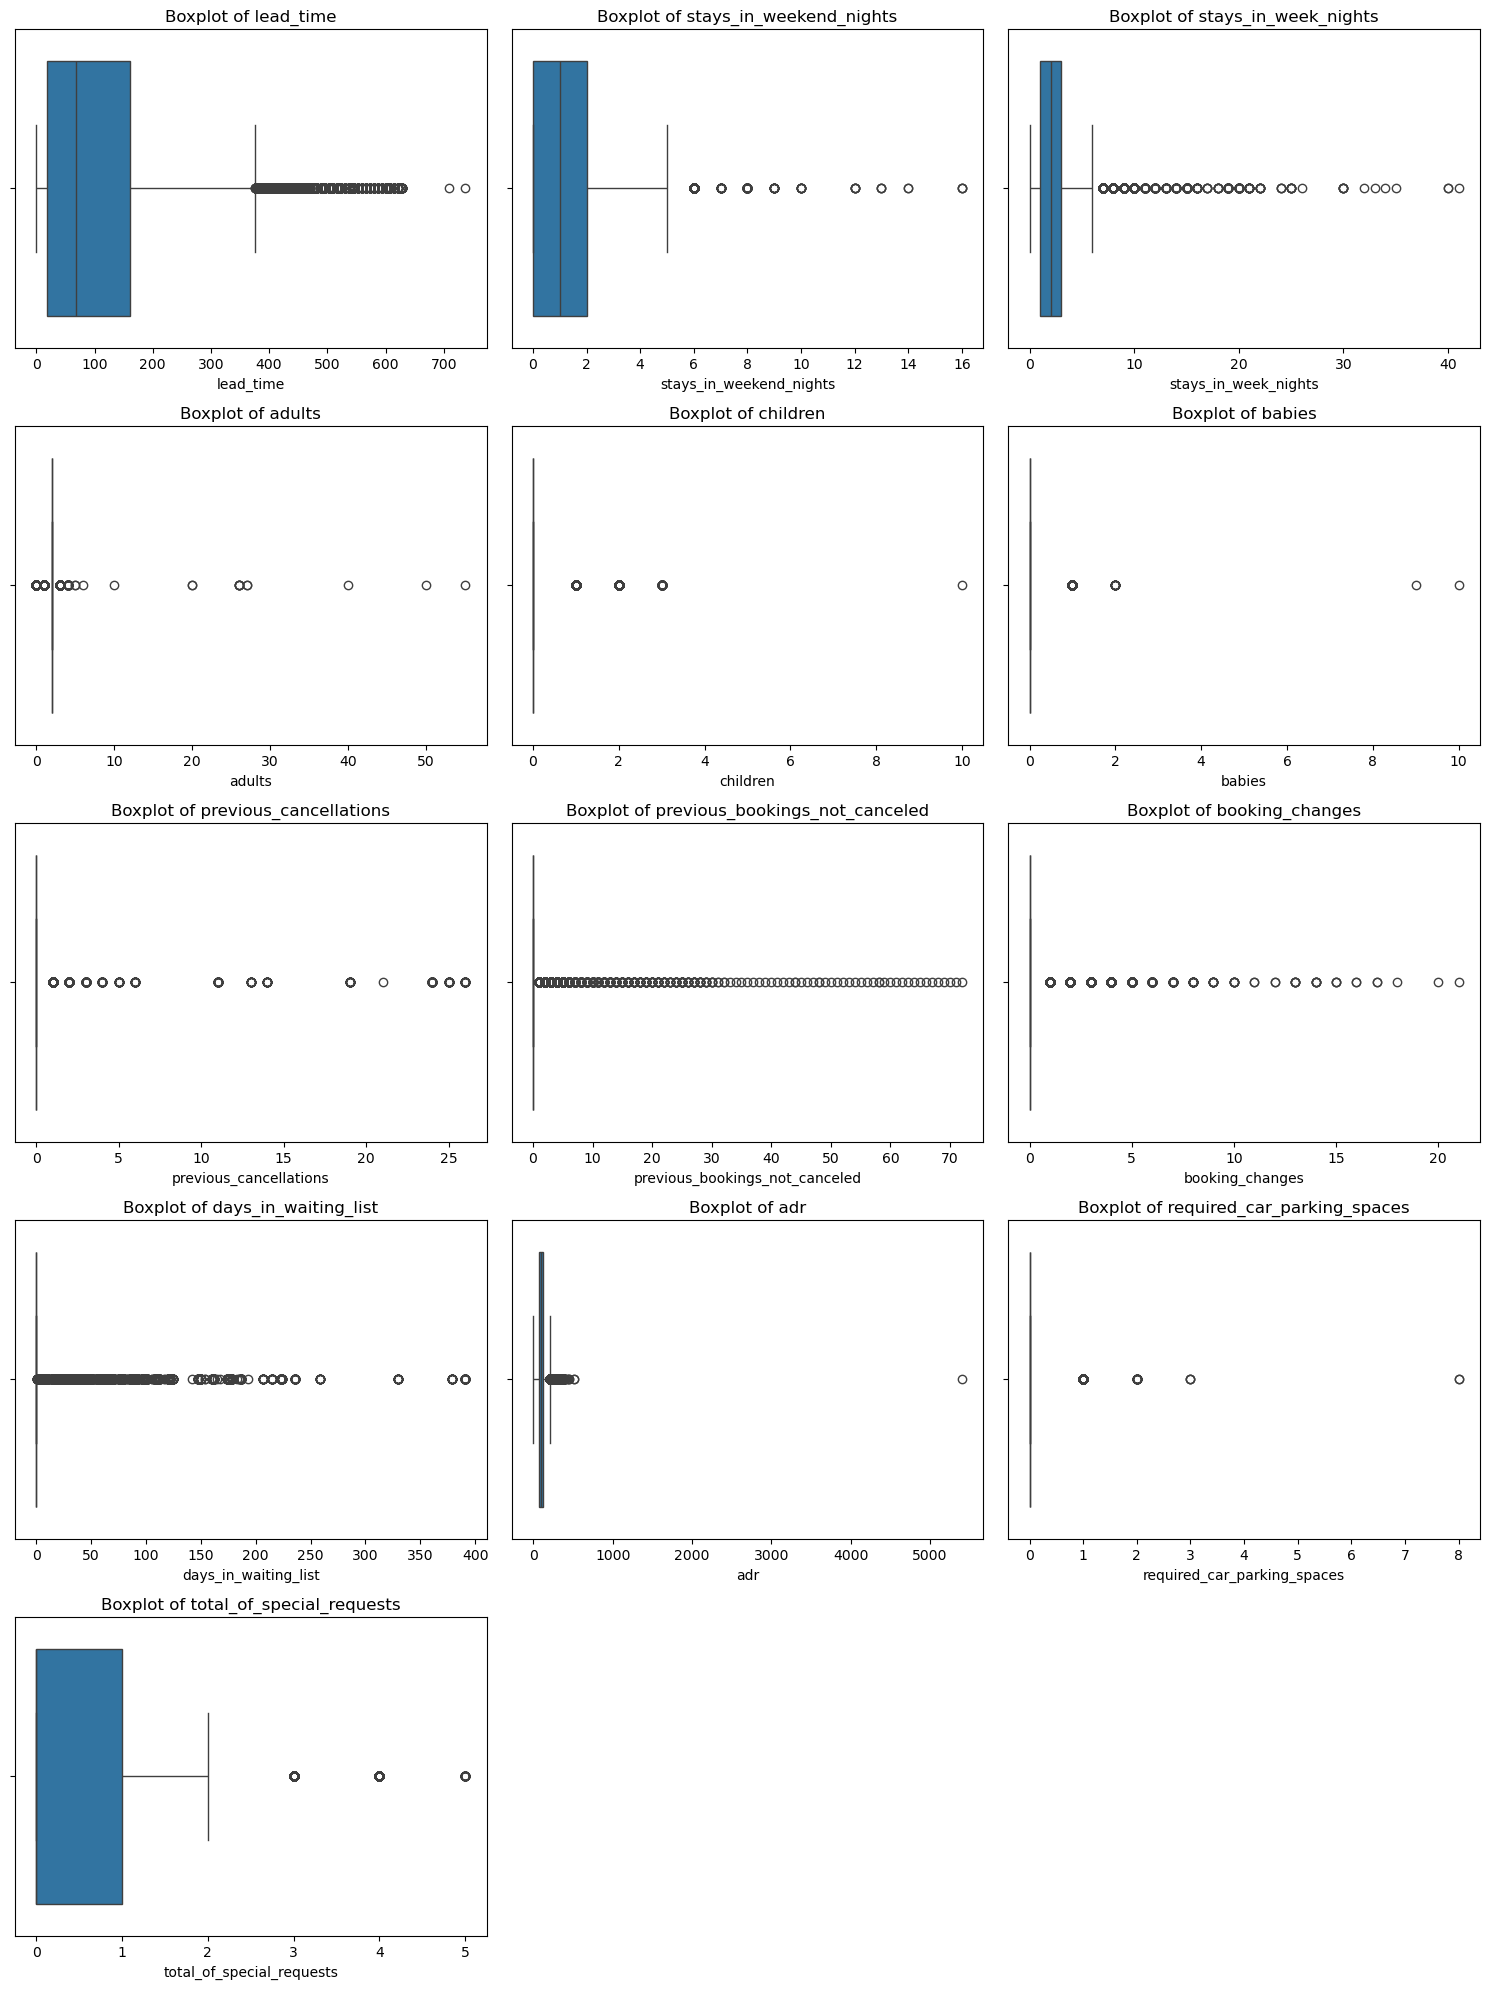

In [23]:
# Set up grid layout
cols_per_row = 3
num_plots = len(num_cols)
rows = math.ceil(num_plots / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

lead_time - heavy but plausible right skew, people do book more than a year in advance. e.g. conferences, weddings. consider log transform for svm? 

weekend - longer stays are odd but possible, perhaps bin into short, medium, long? 

week nights - again, longer stays are possible, consider binning or capping due to skew 

adr - there is one value over 5000, which is for a 1-night stay for 2 adults. next highest is 510. this is clearly a mistake and will be removed. 

children - 10 children is an outlier, but could perhaps be a birthday party or school trip? 

babies - 2 entries - one with 2 adults and 10 babies, another with 1 adult and 9 babies. really? i don't think so. records deleted. 

parking spaces - the requests for 8 parking spaces come from 2 parties of 2 adults - removing

In [24]:
df = df[df['adr'] <= 1000]
df = df[df['babies']<5]
df = df[df['required_car_parking_spaces']<5]

In [25]:
# save data before encoding
df.to_csv('hotel_cleaned_no_encoding.csv', index=False)

# Encoding

Label encoding for hotel, as it is binary. one-hot encoding for the rest as it is not ordinal.

In [26]:
cat_cols = cat_cols.drop('hotel')
cat_cols

Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'deposit_type', 'customer_type'],
      dtype='object')

In [27]:
# label encoding
df['hotel'] = df['hotel'].map({'City Hotel': 0, 'Resort Hotel': 1})

In [28]:
# one-hot
df = pd.get_dummies(df, columns=cat_cols)
df.head()

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_Other,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,0,342,0,0,2,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,1,0,737,0,0,2,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
2,1,0,7,0,1,1,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
3,1,0,13,0,1,1,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
4,1,0,14,0,2,2,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [29]:
# save the final format
df.to_csv('hotel_cleaned.csv', index=False)